# Exercises

We have four exercises in this section:
1. Rewrite the CART method to the Gini index.
2. Use pydot do draw the tree for C4.5 example.
3. Implement the reduced error pruning (REP).
4. Plot OC1 tree, but instead of elements id, print the feature id it was split by.

## Exercise 1: Rewrite the CART method to use Gini index as shown in the lecture

Use Gini index can be calculated with the following equation:
\begin{equation}
I_{G}(X)=1-\sum_{i=1}^{m}p^{2}_{i},
\end{equation}
and
\begin{equation}
I_{G}(\text{feature})=1-\sum_{i=1}^{n}p_{i}*I_{G}(X_{i}).
\end{equation}

You need to fill the ``calculate_gini`` function and change the ``build`` function a bit.

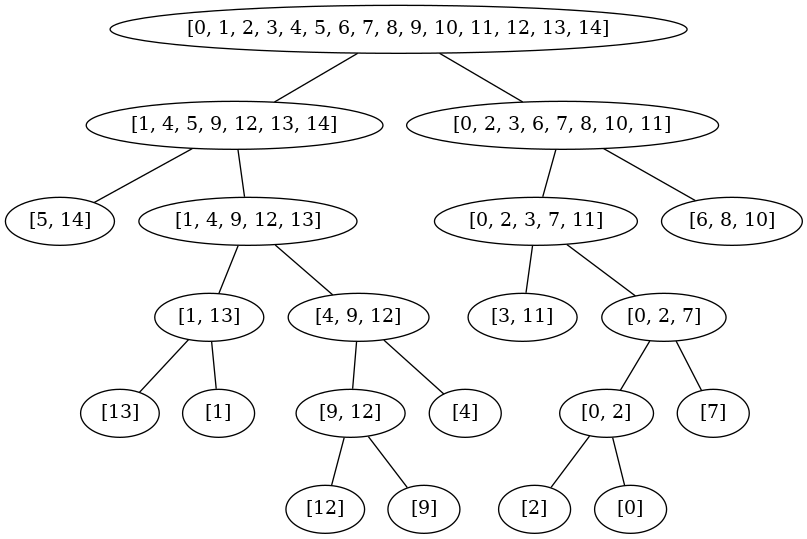

In [1]:
import math
import numpy as np
import pydot
import copy

class BinaryLeaf:

    def __init__(self, elements, labels, ids):
        self.L = None
        self.R = None
        self.elements = elements
        self.split_feature = None
        self.labels = labels
        self.completed = False
        self.ids = ids

    def set_R(self, Rleaf):
        self.R = Rleaf

    def set_L(self, Lleaf):
        self.L = Lleaf

    def set_elements(self, elements):
        self.elements = elements

    def get_elements(self):
        return self.elements

    def set_p(self, threshold):
        self.p = threshold

    def get_L(self):
        return self.L

    def get_R(self):
        return self.R

    def set_completed(self):
        self.completed = True

    def is_completed(self):
        return self.completed

    def get_labels(self):
        return self.labels

    def set_split(self, feature):
        self.split_feature = feature

    def get_split(self):
        return self.split_feature

    def set_ids(self, ids):
        self.ids = ids

    def get_ids(self):
        return self.ids

labels = [1, 1, -1, 1, -1, -1, 1, 1, 1, 1, 1, 1, -1, -1, -1]
data_set = [[1, 1, 2, 2], [2, 1, 2, 2], [1, 1, 1, 2], [1, 2, 1, 2], [2, 3, 2, 2],
            [2, 2, 1, 2], [3, 2, 2, 1], [1, 3, 2, 2], [3, 3, 2, 1], [2, 3, 1, 2],
            [3, 1, 1, 1], [1, 2, 1, 1], [2, 3, 1, 1], [2, 1, 1, 2], [2, 2, 1, 1]]


labels_count = len(np.unique(labels))

ids = list(range(len(data_set)))
root = BinaryLeaf(data_set, labels, ids)
current_node = root

## helper methods:

def get_unique_labels(labels):
    return np.unique(np.array(labels)).tolist()

def get_unique_values(elements):
    features_number = len(elements[0])
    unique = []
    for i in range(features_number):
        features_list = []
        for j in range(len(elements)):
            features_list.append(elements[j][i])
        unique.append(np.unique(np.array(features_list)))
    return unique

def is_leaf_completed(node):
    if node.is_completed():
        if node.get_L() != None and not node.get_L().is_completed():
            return node.get_L()
        elif node.get_R() != None and not node.get_R().is_completed():
            return node.get_R()
        elif node.get_L() == None and node.get_R() == None:
            return None
        elif node.get_L().is_completed() or node.get_R().is_completed():
            new_node = is_leaf_completed(node.get_L())
            if new_node == None:
                return is_leaf_completed(node.get_R())
            else:
                return new_node
        else:
            return None
    return node

def find_leaf_not_completed(root):
    return is_leaf_completed(root)


## CART methods:

def get_split_candidates(unique_values):
    split_list = []
    for i in range(len(unique_values)):
        current_list = []
        temp_list = copy.deepcopy(unique_values)
        current_list.append(temp_list[i])
        del temp_list[i]
        current_list.append(temp_list)
        split_list.append(current_list)
    return split_list


def get_number_of_labels_for_value(elements, column_id, label):
    count = 0
    if not isinstance(elements, list):
        elements_list = [elements]
    else:
        elements_list = elements

    column_elements = get_node_elements_column(column_id)

    for i in range(len(elements_list)):
        for j in range(len(column_elements)):
            if column_elements[j] == elements_list[i]:
                if current_node.labels[j] == label:
                    count = count + 1
    return count


def get_node_elements_column(column_id):
    return np.array(current_node.elements)[..., column_id].tolist()

def count_number_of_elements(elements, column_id):
    count = 0
    if isinstance(elements, list):
        column_elements = get_node_elements_column(column_id)
        for i in range(len(elements)):
            count = count + column_elements.count(elements[i])
    else:
        count = count + get_node_elements_column(column_id).count(elements)
    return count


# fill:
def calculate_gini(X, index):
    count_pos = 0
    count_neg = 0
    for i in np.transpose(current_node.get_elements())[index]:
        if i == X[0]:
            if labels[i] == 1:
                count_pos += 1
            elif labels[i] == -1:
                count_neg += 1
    summ = count_pos+count_neg
    gini_index_1 = 1-(count_pos/(summ))**2-(count_neg/(summ))**2
    
    count_pos = 0
    count_neg = 0
    for i in np.transpose(current_node.get_elements())[index]:
        if i in X[1]:
            if labels[i] == 1:
                count_pos += 1
            elif labels[i] == -1:
                count_neg += 1
    summ = count_pos+count_neg
    gini_index_2 = 1-(count_pos/(summ))**2-(count_neg/(summ))**2
    
    return gini_index_1, gini_index_2 
    
def check_completed(labels, elements):
    ratio = len(get_unique_labels(labels))
    if ratio == 1:
        return True
    elements = sorted(elements)
    duplicated = [elements[i] for i in range(len(elements)) if i == 0 or elements[i] != elements[i - 1]]
    if len(duplicated) == 1:
        return True
    return False

def split_node(current_node, value, split_id, split_history):
    left_leaf = []
    left_leaf_labels = []
    left_leaf_ids = []
    right_leaf = []
    right_leaf_labels = []
    right_leaf_ids = []
    for i in range(len(current_node.elements)):
        if current_node.elements[i][split_id] == value:
            left_leaf.append(current_node.elements[i])
            left_leaf_labels.append(current_node.labels[i])
            left_leaf_ids.append(current_node.ids[i])
        else:
            right_leaf.append(current_node.elements[i])
            right_leaf_labels.append(current_node.labels[i])
            right_leaf_ids.append(current_node.ids[i])
    if len(right_leaf_labels) == 0 or len(left_leaf_labels) == 0:
        current_node.set_completed()
        return current_node, split_history
    split_history.append([str(current_node.ids), str(left_leaf_ids)])
    split_history.append([str(current_node.ids), str(right_leaf_ids)])
    current_node.set_L(BinaryLeaf(left_leaf, left_leaf_labels, left_leaf_ids))
    current_node.set_R(BinaryLeaf(right_leaf, right_leaf_labels, right_leaf_ids))
    current_node.set_split(split_id)
    current_node.set_completed()
    if check_completed(left_leaf_labels, left_leaf):
        current_node.L.set_completed()
    if check_completed(right_leaf_labels, right_leaf):
        current_node.R.set_completed()
    return current_node, split_history

def get_current_node():
    return find_leaf_not_completed()


def build(root_node):
    current_node = root_node
    stop_criterion = False
    split_history = []
    while stop_criterion == False:
        unique_values = get_unique_values(current_node.get_elements())
        min_unique_id = 0
        min_split_id = 0
        min_value = np.inf
        for i in range(len(unique_values)):  # co gdy len(unique) == 1 ?
            if len(unique_values[i]) == 1:
                continue
            split_candidates = get_split_candidates(unique_values[i].tolist())
            for j in range(len(split_candidates)):
                # change here:
                prob_feature = len(np.where(np.transpose(current_node.get_elements())[i]==split_candidates[j][0])[0])/len(labels)
                gini = calculate_gini(split_candidates[j], i) #gini_index
                current_value = prob_feature*gini[0]+(1-prob_feature)*gini[1]
                if min_value > current_value:
                    min_unique_id = i
                    min_split_id = j
                    min_value = current_value
        current_node, split_history = split_node(current_node, unique_values[min_unique_id][min_split_id], min_unique_id, split_history)
        new_node = find_leaf_not_completed(root_node)
        if new_node != None:
            current_node = new_node
        else:
            stop_criterion = True
    return root_node, split_history

def plot_tree(split_history):
    tree = pydot.Dot(graph_type='graph')
    for split in split_history:
        new_edge = pydot.Edge(split[0], split[1], fillcolor = 'red')
        tree.add_edge(new_edge)
    tree.write('cart_tree.png', format='png')


cart_tree, split_history = build(current_node)
plot_tree(split_history)

from IPython.display import Image
Image(filename='cart_tree.png') 

## Exercise 2: Use pydot do draw the tree for C4.5 example

Fill the code below.

5

In [42]:
%store -r split_history_c45

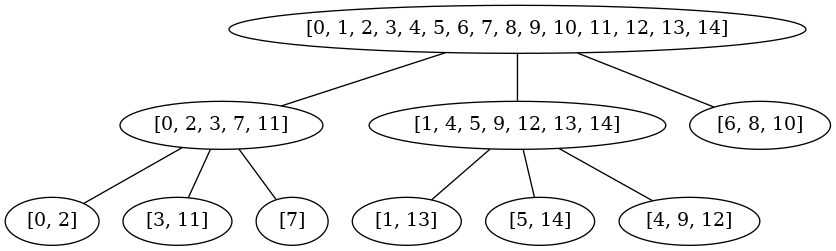

In [45]:
def plot_tree(split_history):
    tree = pydot.Dot(graph_type='graph')
    for split in split_history:
        new_edge = pydot.Edge(split[0], split[1], fillcolor = 'red')
        tree.add_edge(new_edge)
    tree.write('c45_tree.png', format='png')
    
plot_tree(split_history_c45)

from IPython.display import Image
Image(filename='c45_tree.png')

## Exercise 3: Implement the reduced error pruning (REP)

Implement the REP method and use it on the tree created with OC1 classifier. You need to the following:
- implement the accuracy function,
- manipulate the data to go through the path of the tree.

The REP method checkes the accuracy at each node and prune the node if the split gives a lower accuracy. Check the node as ``validated`` when checked and ``completed`` when pruned. When pruned set also the leafs to ``None``.

In [19]:
import math
import numpy as np
import copy

test_labels = [1,1,-1,-1,1,1,1,-1]
test_data_set = [[1,1,2,2],[3,2,1,2],[2,3,1,2],
                [2,2,1,2],[1,3,2,2],[2,1,1,2],
                [3,1,2,1],[2,1,2,2]]

labels = [1,1,-1,1,-1,-1,1,1,1,1,1,1,-1,-1,-1]
data_set = [[1,1,2,2],[2,1,2,2],[1,1,1,2],[1,2,1,2],[2,3,2,2],
                [2,2,1,2],[3,2,2,1],[1,3,2,2],[3,3,2,1],[2,3,1,2],
                [3,1,1,1],[1,2,1,1],[2,3,1,1],[2,1,1,2],[2,2,1,1]]

class BinaryLeaf:

    def __init__(self, elements, labels, ids):
        self.L = None
        self.R = None
        self.elements = elements
        self.split_feature = None
        self.split_value = None
        self.labels = labels
        self.completed = False
        self.ids = ids
        self.validated = False

    def set_R(self, Rleaf):
        self.R = Rleaf

    def set_L(self, Lleaf):
        self.L = Lleaf

    def set_elements(self, elements):
        self.elements = elements

    def get_elements(self):
        return self.elements

    def set_p(self, threshold):
        self.p = threshold

    def get_L(self):
        return self.L

    def get_R(self):
        return self.R

    def set_completed(self):
        self.completed = True

    def is_completed(self):
        return self.completed

    def get_labels(self):
        return self.labels

    def set_split(self, feature):
        self.split_feature = feature

    def get_split(self):
        return self.split_feature

    def set_split_value(self, value):
        self.split_value = value

    def get_split_value(self):
        return self.split_value

    def set_validated(self):
        self.validated = True

    def is_validated(self):
        return self.validated

    def set_ids(self, ids):
        self.ids = ids

    def get_ids(self):
        return self.ids


labels_count = len(np.unique(labels))

ids = list(range(len(data_set)))
root = BinaryLeaf(data_set, labels, ids)
current_node = root


def get_unique_labels(labels):
    return np.unique(np.array(labels)).tolist()


def get_unique_values(elements):
    features_number = len(elements[0])
    unique = []
    for i in range(features_number):
        features_list = []
        for j in range(len(elements)):
            features_list.append(elements[j][i])
        unique.append(np.unique(np.array(features_list)))
    return unique


def is_leaf_completed(node):
    if node.is_completed():
        if node.get_L() != None and not node.get_L().is_completed():
            return node.get_L()
        elif node.get_R() != None and not node.get_R().is_completed():
            return node.get_R()
        elif node.get_L() == None and node.get_R() == None:
            return None
        elif node.get_L().is_completed() or node.get_R().is_completed():
            new_node = is_leaf_completed(node.get_L())
            if new_node == None:
                return is_leaf_completed(node.get_R())
            else:
                return new_node
        else:
            return None
    return node


def find_leaf_not_completed(root):
    return is_leaf_completed(root)


def get_split_candidates(unique_values):
    split_list = []
    for i in range(len(unique_values)):
        current_list = []
        temp_list = copy.deepcopy(unique_values)
        current_list.append(temp_list[i])
        del temp_list[i]
        current_list.append(temp_list)
        split_list.append(current_list)
    return split_list


def get_number_of_labels_for_value(elements, column_id, label):
    count = 0
    if not isinstance(elements, list):
        elements_list = [elements]
    else:
        elements_list = elements

    column_elements = get_node_elements_column(column_id)

    for i in range(len(elements_list)):
        for j in range(len(column_elements)):
            if column_elements[j] == elements_list[i]:
                if current_node.labels[j] == label:
                    count = count + 1
    return count


def get_node_elements_column(column_id):
    return np.array(current_node.elements)[..., column_id].tolist()


def count_number_of_elements(elements, column_id):
    count = 0
    if isinstance(elements, list):
        column_elements = get_node_elements_column(column_id)
        for i in range(len(elements)):
            count = count + column_elements.count(elements[i])
    else:
        count = count + get_node_elements_column(column_id).count(elements)
    return count


def calculate_omega(elements, column_id):
    t_l = count_number_of_elements(elements[0], column_id)
    t_r = count_number_of_elements(elements[1], column_id)
    p_l = t_l * 1.0 / len(current_node.elements) * 1.0
    p_r = t_r * 1.0 / len(current_node.elements) * 1.0

    sum_p = 0
    labels = get_unique_labels(current_node.labels)
    for i in range(labels_count):
        p_class_t_l = (get_number_of_labels_for_value(elements[0], column_id, labels[i]) * 1.0) / (
                count_number_of_elements(elements[0], column_id) * 1.0)
        p_class_t_r = (get_number_of_labels_for_value(elements[1], column_id, labels[i]) * 1.0) / (
                count_number_of_elements(elements[1], column_id) * 1.0)
        sum_p = sum_p + math.fabs(p_class_t_l - p_class_t_r)
    return 2.0 * p_l * p_r * sum_p


def check_completed(labels, elements):
    ratio = len(get_unique_labels(labels))
    if ratio == 1:
        return True
    elements = sorted(elements)
    duplicated = [elements[i] for i in range(len(elements)) if i == 0 or elements[i] != elements[i - 1]]
    if len(duplicated) == 1:
        return True
    return False


def split_node(current_node, value, split_id, split_history):
    left_leaf = []
    left_leaf_labels = []
    left_leaf_ids = []
    right_leaf = []
    right_leaf_labels = []
    right_leaf_ids = []
    for i in range(len(current_node.elements)):
        if current_node.elements[i][split_id] == value:
            left_leaf.append(current_node.elements[i])
            left_leaf_labels.append(current_node.labels[i])
            left_leaf_ids.append(current_node.ids[i])
        else:
            right_leaf.append(current_node.elements[i])
            right_leaf_labels.append(current_node.labels[i])
            right_leaf_ids.append(current_node.ids[i])
    if len(right_leaf_labels) == 0 or len(left_leaf_labels) == 0:
        current_node.set_completed()
        return current_node, split_history
    split_history.append([str(current_node.ids), str(left_leaf_ids)])
    split_history.append([str(current_node.ids), str(right_leaf_ids)])
    current_node.set_L(BinaryLeaf(left_leaf, left_leaf_labels, left_leaf_ids))
    current_node.set_R(BinaryLeaf(right_leaf, right_leaf_labels, right_leaf_ids))
    current_node.set_split(split_id)
    current_node.set_split_value(value)
    current_node.set_completed()
    if check_completed(left_leaf_labels, left_leaf):
        current_node.L.set_completed()
    if check_completed(right_leaf_labels, right_leaf):
        current_node.R.set_completed()
    return current_node, split_history

def get_current_node():
    return find_leaf_not_completed()

def build(root_node):
    current_node = root_node
    stop_criterion = False
    split_history = []
    while stop_criterion == False:
        unique_values = get_unique_values(current_node.get_elements())
        max_unique_id = 0
        max_split_id = 0
        max_value = 0
        for i in range(len(unique_values)):
            if len(unique_values[i]) == 1:
                continue
            split_candidates = get_split_candidates(unique_values[i].tolist())
            for j in range(len(split_candidates)):
                current_value = calculate_omega(split_candidates[j], i)
                if max_value < current_value:
                    max_unique_id = i
                    max_split_id = j
                    max_value = current_value
        current_node, split_history = split_node(current_node, unique_values[max_unique_id][max_split_id],
                                                 max_unique_id, split_history)
        new_node = find_leaf_not_completed(root_node)
        if new_node != None:
            current_node = new_node
        else:
            stop_criterion = True
    return root_node, split_history

cart_tree, split_history_cart = build(current_node)

Fill the gap below:

In [67]:
"""
implement the accuracy function,
manipulate the data to go through the path of the tree.
The REP method checkes the accuracy at each node and prune the node if the split gives a lower accuracy. 
Check the node as validated when checked and completed when pruned. When pruned set also the leafs to None
"""
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
  
def fill_test_data(cart_tree, test_data, test_ids, split_history):
    level = cart_tree
    level.set_elements(test_data)
    add_R = []
    add_L = []
    stop_criterion = False
    while level.split_feature != None and stop_criterion != True:
        for i in range(len(test_data)):
            if test_data[i][level.split_feature] == level.split_value:
                add_R.append(i)
            else:
                add_L.append(i)
        
        split_history.append([str(test_ids), str(test_ids[add_L])])
        split_history.append([str(test_ids), str(test_ids[add_R])])
        #if test_ids[add_R] != []:
        fill_test_data(level.get_R(), test_data[add_R], test_ids[add_R], split_history)
        #if test_ids[add_L] != []:
        fill_test_data(level.get_L(), test_data[add_L], test_ids[add_L], split_history) 
        
        stop_criterion = True
    return split_history

def get_curent_level(node):
    if type(node) == list:
        level = []
        for leaf in node:
            if leaf != None:
                level.append(leaf.get_R())
                level.append(leaf.get_L())
        return level
    return [node.get_R(),node.get_L()]
    

def get_accuracy(test_data_set, test_labels):
    tmp = np.mean(test_labels)
    return abs(tmp)
    # fill the gap

def validate_rep(cart_tree, test_data_set, test_labels):
    ebene = 0
    level = [cart_tree.get_R(),cart_tree.get_L()]
    old_accuracy = 0.0
    while level != None:
        for leaf in level:
            accuracy = get_accuracy(test_data_set, test_labels)
            if accuracy < old_accuracy:
                print("To be pruned:")
                print(leaf.elements)
                print(leaf.labels)
                leaf.set_completed()
            else:
                old_accuracy = accuracy
            # fill the gap
        if level != None:
            level = get_curent_level(level)
            ebene += 1
        print(ebene)

test_ids = list(range(len(test_data_set)))
cart_tree2 = copy.deepcopy(cart_tree)
split_history = []
split_history = fill_test_data(cart_tree2, np.array(test_data_set), np.array(test_ids), split_history)

validate_rep(cart_tree2, test_data_set, test_labels)
"""test_data_set, test_labels
level = [cart_tree.get_R(),cart_tree.get_L()]
cart_tree.get_L().labels"""

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


2312
2313
2314
2315
2316
2317
2318
2319
2320
2321
2322
2323
2324
2325
2326
2327
2328
2329
2330
2331
2332
2333
2334
2335
2336
2337
2338
2339
2340
2341
2342
2343
2344
2345
2346
2347
2348
2349
2350
2351
2352
2353
2354
2355
2356
2357
2358
2359
2360
2361
2362
2363
2364
2365
2366
2367
2368
2369
2370
2371
2372
2373
2374
2375
2376
2377
2378
2379
2380
2381
2382
2383
2384
2385
2386
2387
2388
2389
2390
2391
2392
2393
2394
2395
2396
2397
2398
2399
2400
2401
2402
2403
2404
2405
2406
2407
2408
2409
2410
2411
2412
2413
2414
2415
2416
2417
2418
2419
2420
2421
2422
2423
2424
2425
2426
2427
2428
2429
2430
2431
2432
2433
2434
2435
2436
2437
2438
2439
2440
2441
2442
2443
2444
2445
2446
2447
2448
2449
2450
2451
2452
2453
2454
2455
2456
2457
2458
2459
2460
2461
2462
2463
2464
2465
2466
2467
2468
2469
2470
2471
2472
2473
2474
2475
2476
2477
2478
2479
2480
2481
2482
2483
2484
2485
2486
2487
2488
2489
2490
2491
2492
2493
2494
2495
2496
2497
2498
2499
2500
2501
2502
2503
2504
2505
2506
2507
2508
2509
2510
2511


3972
3973
3974
3975
3976
3977
3978
3979
3980
3981
3982
3983
3984
3985
3986
3987
3988
3989
3990
3991
3992
3993
3994
3995
3996
3997
3998
3999
4000
4001
4002
4003
4004
4005
4006
4007
4008
4009
4010
4011
4012
4013
4014
4015
4016
4017
4018
4019
4020
4021
4022
4023
4024
4025
4026
4027
4028
4029
4030
4031
4032
4033
4034
4035
4036
4037
4038
4039
4040
4041
4042
4043
4044
4045
4046
4047
4048
4049
4050
4051
4052
4053
4054
4055
4056
4057
4058
4059
4060
4061
4062
4063
4064
4065
4066
4067
4068
4069
4070
4071
4072
4073
4074
4075
4076
4077
4078
4079
4080
4081
4082
4083
4084
4085
4086
4087
4088
4089
4090
4091
4092
4093
4094
4095
4096
4097
4098
4099
4100
4101
4102
4103
4104
4105
4106
4107
4108
4109
4110
4111
4112
4113
4114
4115
4116
4117
4118
4119
4120
4121
4122
4123
4124
4125
4126
4127
4128
4129
4130
4131
4132
4133
4134
4135
4136
4137
4138
4139
4140
4141
4142
4143
4144
4145
4146
4147
4148
4149
4150
4151
4152
4153
4154
4155
4156
4157
4158
4159
4160
4161
4162
4163
4164
4165
4166
4167
4168
4169
4170
4171


6071
6072
6073
6074
6075
6076
6077
6078
6079
6080
6081
6082
6083
6084
6085
6086
6087
6088
6089
6090
6091
6092
6093
6094
6095
6096
6097
6098
6099
6100
6101
6102
6103
6104
6105
6106
6107
6108
6109
6110
6111
6112
6113
6114
6115
6116
6117
6118
6119
6120
6121
6122
6123
6124
6125
6126
6127
6128
6129
6130
6131
6132
6133
6134
6135
6136
6137
6138
6139
6140
6141
6142
6143
6144
6145
6146
6147
6148
6149
6150
6151
6152
6153
6154
6155
6156
6157
6158
6159
6160
6161
6162
6163
6164
6165
6166
6167
6168
6169
6170
6171
6172
6173
6174
6175
6176
6177
6178
6179
6180
6181
6182
6183
6184
6185
6186
6187
6188
6189
6190
6191
6192
6193
6194
6195
6196
6197
6198
6199
6200
6201
6202
6203
6204
6205
6206
6207
6208
6209
6210
6211
6212
6213
6214
6215
6216
6217
6218
6219
6220
6221
6222
6223
6224
6225
6226
6227
6228
6229
6230
6231
6232
6233
6234
6235
6236
6237
6238
6239
6240
6241
6242
6243
6244
6245
6246
6247
6248
6249
6250
6251
6252
6253
6254
6255
6256
6257
6258
6259
6260
6261
6262
6263
6264
6265
6266
6267
6268
6269
6270


7738
7739
7740
7741
7742
7743
7744
7745
7746
7747
7748
7749
7750
7751
7752
7753
7754
7755
7756
7757
7758
7759
7760
7761
7762
7763
7764
7765
7766
7767
7768
7769
7770
7771
7772
7773
7774
7775
7776
7777
7778
7779
7780
7781
7782
7783
7784
7785
7786
7787
7788
7789
7790
7791
7792
7793
7794
7795
7796
7797
7798
7799
7800
7801
7802
7803
7804
7805
7806
7807
7808
7809
7810
7811
7812
7813
7814
7815
7816
7817
7818
7819
7820
7821
7822
7823
7824
7825
7826
7827
7828
7829
7830
7831
7832
7833
7834
7835
7836
7837
7838
7839
7840
7841
7842
7843
7844
7845
7846
7847
7848
7849
7850
7851
7852
7853
7854
7855
7856
7857
7858
7859
7860
7861
7862
7863
7864
7865
7866
7867
7868
7869
7870
7871
7872
7873
7874
7875
7876
7877
7878
7879
7880
7881
7882
7883
7884
7885
7886
7887
7888
7889
7890
7891
7892
7893
7894
7895
7896
7897
7898
7899
7900
7901
7902
7903
7904
7905
7906
7907
7908
7909
7910
7911
7912
7913
7914
7915
7916
7917
7918
7919
7920
7921
7922
7923
7924
7925
7926
7927
7928
7929
7930
7931
7932
7933
7934
7935
7936
7937


9725
9726
9727
9728
9729
9730
9731
9732
9733
9734
9735
9736
9737
9738
9739
9740
9741
9742
9743
9744
9745
9746
9747
9748
9749
9750
9751
9752
9753
9754
9755
9756
9757
9758
9759
9760
9761
9762
9763
9764
9765
9766
9767
9768
9769
9770
9771
9772
9773
9774
9775
9776
9777
9778
9779
9780
9781
9782
9783
9784
9785
9786
9787
9788
9789
9790
9791
9792
9793
9794
9795
9796
9797
9798
9799
9800
9801
9802
9803
9804
9805
9806
9807
9808
9809
9810
9811
9812
9813
9814
9815
9816
9817
9818
9819
9820
9821
9822
9823
9824
9825
9826
9827
9828
9829
9830
9831
9832
9833
9834
9835
9836
9837
9838
9839
9840
9841
9842
9843
9844
9845
9846
9847
9848
9849
9850
9851
9852
9853
9854
9855
9856
9857
9858
9859
9860
9861
9862
9863
9864
9865
9866
9867
9868
9869
9870
9871
9872
9873
9874
9875
9876
9877
9878
9879
9880
9881
9882
9883
9884
9885
9886
9887
9888
9889
9890
9891
9892
9893
9894
9895
9896
9897
9898
9899
9900
9901
9902
9903
9904
9905
9906
9907
9908
9909
9910
9911
9912
9913
9914
9915
9916
9917
9918
9919
9920
9921
9922
9923
9924


11451
11452
11453
11454
11455
11456
11457
11458
11459
11460
11461
11462
11463
11464
11465
11466
11467
11468
11469
11470
11471
11472
11473
11474
11475
11476
11477
11478
11479
11480
11481
11482
11483
11484
11485
11486
11487
11488
11489
11490
11491
11492
11493
11494
11495
11496
11497
11498
11499
11500
11501
11502
11503
11504
11505
11506
11507
11508
11509
11510
11511
11512
11513
11514
11515
11516
11517
11518
11519
11520
11521
11522
11523
11524
11525
11526
11527
11528
11529
11530
11531
11532
11533
11534
11535
11536
11537
11538
11539
11540
11541
11542
11543
11544
11545
11546
11547
11548
11549
11550
11551
11552
11553
11554
11555
11556
11557
11558
11559
11560
11561
11562
11563
11564
11565
11566
11567
11568
11569
11570
11571
11572
11573
11574
11575
11576
11577
11578
11579
11580
11581
11582
11583
11584
11585
11586
11587
11588
11589
11590
11591
11592
11593
11594
11595
11596
11597
11598
11599
11600
11601
11602
11603
11604
11605
11606
11607
11608
11609
11610
11611
11612
11613
11614
11615
11616
1161

13356
13357
13358
13359
13360
13361
13362
13363
13364
13365
13366
13367
13368
13369
13370
13371
13372
13373
13374
13375
13376
13377
13378
13379
13380
13381
13382
13383
13384
13385
13386
13387
13388
13389
13390
13391
13392
13393
13394
13395
13396
13397
13398
13399
13400
13401
13402
13403
13404
13405
13406
13407
13408
13409
13410
13411
13412
13413
13414
13415
13416
13417
13418
13419
13420
13421
13422
13423
13424
13425
13426
13427
13428
13429
13430
13431
13432
13433
13434
13435
13436
13437
13438
13439
13440
13441
13442
13443
13444
13445
13446
13447
13448
13449
13450
13451
13452
13453
13454
13455
13456
13457
13458
13459
13460
13461
13462
13463
13464
13465
13466
13467
13468
13469
13470
13471
13472
13473
13474
13475
13476
13477
13478
13479
13480
13481
13482
13483
13484
13485
13486
13487
13488
13489
13490
13491
13492
13493
13494
13495
13496
13497
13498
13499
13500
13501
13502
13503
13504
13505
13506
13507
13508
13509
13510
13511
13512
13513
13514
13515
13516
13517
13518
13519
13520
13521
1352

KeyboardInterrupt: 

In [57]:
cart_tree2.get_R().get_R().get_R()

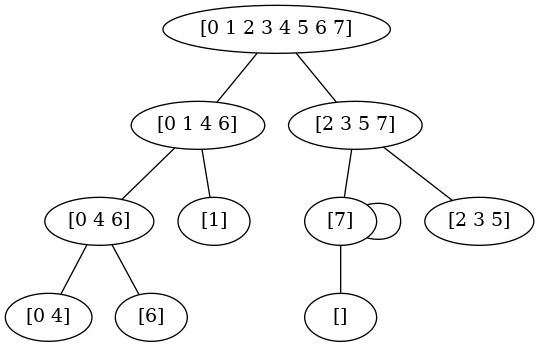

In [62]:
def plot_tree(split_history):
    tree = pydot.Dot(graph_type='graph')
    for split in split_history:
        new_edge = pydot.Edge(split[0], split[1], fillcolor = 'red')
        tree.add_edge(new_edge)
    tree.write('my_tree.png', format='png')

plot_tree(split_history)    


from IPython.display import Image
Image(filename='my_tree.png')

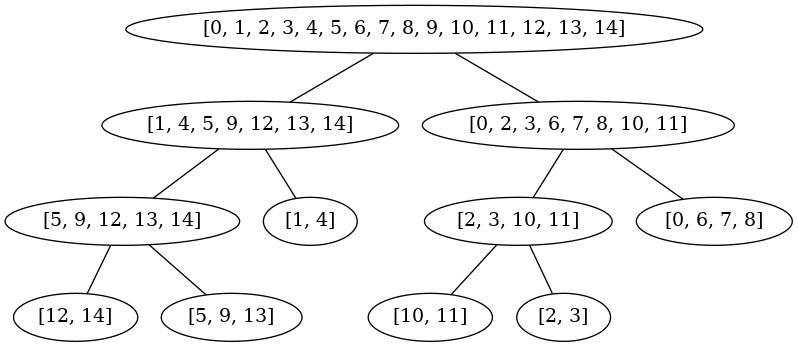

In [58]:
def plot_tree(split_history):
    tree = pydot.Dot(graph_type='graph')
    for split in split_history:
        new_edge = pydot.Edge(split[0], split[1], fillcolor = 'red')
        tree.add_edge(new_edge)
    tree.write('cart2_tree.png', format='png')

plot_tree(split_history_cart)    


from IPython.display import Image
Image(filename='cart2_tree.png')

## Exercise 4: Plot OC1 tree, but instead of elements id, print the feature id it was split by

To make the task done, you need to change the functions:
- ``build_level``,
- update the ``BinaryLeaf`` in two places to add the setters/getters and the feature and feature value split data.


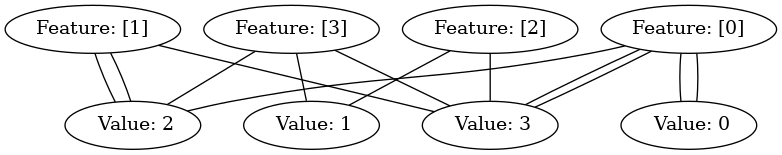

In [78]:
from random import *

class BinaryLeaf:

    def __init__(self, elements, labels, ids):
        self.L = None
        self.R = None
        self.p = None
        self.elements = elements
        # add here features and values
        self.split_feature = None
        self.split_value = None
        self.labels = labels
        self.completed = False
        self.ids = ids

    def set_R(self, Rleaf):
        self.R = Rleaf

    def set_L(self, Lleaf):
        self.L = Lleaf

    def set_elements(self, elements):
        self.elements = elements

    def get_elements(self):
        return self.elements

    def set_p(self, threshold):
        self.p = threshold

    def get_L(self):
        return self.L

    def get_R(self):
        return self.R

    def set_completed(self):
        self.completed = True

    def is_completed(self):
        return self.completed

    def get_labels(self):
        return self.labels

    # fill the methods here
    
    def set_split(self, feature):
        self.split_feature = feature

    def get_split(self):
        return self.split_feature

    def set_split_value(self, value):
        self.split_value = value

    def get_split_value(self):
        return self.split_value

    def set_ids(self, ids):
        self.ids = ids

    def get_ids(self):
        return self.ids

labels = [1, 1, -1, 1, -1, -1, 1, 1, 1, 1, 1, 1, -1, -1, -1]
data_set = [[1, 1, 2, 2], [2, 1, 2, 2], [1, 1, 1, 2], [1, 2, 1, 2], [2, 3, 2, 2],
            [2, 2, 1, 2], [3, 2, 2, 1], [1, 3, 2, 2], [3, 3, 2, 1], [2, 3, 1, 2],
            [3, 1, 1, 1], [1, 2, 1, 1], [2, 3, 1, 1], [2, 1, 1, 2], [2, 2, 1, 1]]


labels_count = len(np.unique(labels))

ids = list(range(len(data_set)))
root = BinaryLeaf(data_set, labels, ids)
current_node = root
R = 10

## helper methods:

def compute_v(element, scv):
    return np.sum(np.multiply(element, scv[:-1])) + scv[-1]

def compare_two_leafs(leaf1, leaf2):
    labels1 = leaf1.labels
    labels2 = leaf2.labels
    if len(labels1) == len(labels2):
        for i in range(len(labels1)):
            if labels1[i] != labels2[i]:
                return False
        return True
    return False

def is_leaf_completed(node):
    if node.is_completed():
        if node.get_L() != None and not node.get_L().is_completed():
            return node.get_L()
        elif node.get_R() != None and not node.get_R().is_completed():
            return node.get_R()
        elif node.get_L() == None and node.get_R() == None:
            return None
        elif node.get_L().is_completed() or node.get_R().is_completed():
            new_node = is_leaf_completed(node.get_L())
            if new_node == None:
                return is_leaf_completed(node.get_R())
            else:
                return new_node
        else:
            return None
    return node

## oc1

def calculate_gini(labels):
    unique_labels = np.unique(labels)
    gini = 0
    for label in unique_labels:
        found = np.where(labels == label)
        gini = gini + len(found)/len(labels)
    return np.square(gini)

def get_all_possible_splits_by_gini(leaf):
    leaf_elements = leaf.elements
    labels = leaf.labels
    ginis = []
    for i in range(len(leaf_elements[0])):
        feature_ginis = []
        feature_column = np.array(leaf_elements)[:, i]
        for feature in feature_column:
            distinguish = feature_column <= feature
            left_labels  = np.array(labels)[distinguish]
            right_labels = np.array(labels)[~distinguish]
            gini = 1 - calculate_gini(left_labels) - calculate_gini(right_labels)
            feature_ginis.append([feature,gini])
        ginis.append(min(feature_ginis))
    return ginis


def find_current_level_data(root):
    return is_leaf_completed(root)

def divide_data_hiperplane(leaf,scv):
    below = []
    above = []
    below_labels = []
    above_labels = []
    below_ids = []
    above_ids = []
    for i in range(len(leaf.elements)):
        v = compute_v(leaf.elements[i],scv) > 0
        if v:
            above.append(leaf.elements[i])
            above_labels.append(leaf.labels[i])
            above_ids.append(leaf.ids[i])            
        else:
            below.append(leaf.elements[i])
            below_labels.append(leaf.labels[i])
            below_ids.append(leaf.ids[i])    
    return np.array(below), np.array(above), np.array(below_labels), np.array(above_labels), below_ids, above_ids

def get_coefficiency(splits):
    splits = np.array(splits)
    scv = np.zeros(len(splits)+1)
    min_split_index = np.argmin(splits[:,1])
    scv[min_split_index] = 1
    scv[-1] = -splits[min_split_index][1]
    return scv

def compute_u(element, scv, feature):
    return (scv[feature] * element[feature] - compute_v(element, scv)) / element[feature]

def sort_u(element):
    return np.sort(element)

def perturb(leaf, scv, feature, old_gini):
    u=[]
    for element in leaf.elements:
        u.append(compute_u(element, scv, feature))
    splits = sort_u(np.array(u))
    am = []
    for split in splits:
        new_scv = scv
        new_scv[feature] = split
        below, above, below_label, above_label, below_ids, above_ids = divide_data_hiperplane(leaf, scv)
        gini = 1 - (calculate_gini(below_label) - calculate_gini(above_label))
        am.append([new_scv, gini])
    am = np.array(am)
    best_split_index = np.argmin(am[:,1])
    if am[best_split_index][1] < old_gini:
        return am[best_split_index][1], am[best_split_index][0]
    elif am[best_split_index][1] == old_gini:
        if random() < 0.3:
            return am[best_split_index][1], am[best_split_index][0]
    return old_gini, scv


def build_level(root, split_history):
    leaf = find_current_level_data(root)
    if leaf == None:
        return
    splits = get_all_possible_splits_by_gini(leaf)
    split_coefficiency_vector = get_coefficiency(splits)
    below,above, below_label, above_label, below_ids, above_ids = divide_data_hiperplane(leaf,split_coefficiency_vector)
    gini = 1 - calculate_gini(below_label) - calculate_gini(above_label)
    for c in range(R):
        feature = randint(0,len(leaf.elements[0])-1)
        gini, split_coefficiency_vector = perturb(leaf, split_coefficiency_vector, feature, gini)
        below, above, below_label, above_label, below_ids, above_ids = divide_data_hiperplane(leaf,split_coefficiency_vector)
    left_leaf = BinaryLeaf(below, below_label, below_ids)
    right_leaf = BinaryLeaf(above, above_label, above_ids)
    #split_history.append([str(leaf.ids), str(left_leaf.ids)])
    #split_history.append([str(leaf.ids), str(right_leaf.ids)])
    leaf.set_completed()
    # change here
    #print(split_history[-2:])
    #print(splits)
    #print(split_coefficiency_vector)
    #print(feature)
    leaf.split_value = feature

    tol = 1e-15
    split_coefficiency_vector[:-1][abs(split_coefficiency_vector[:-1]) < tol] = 0.0
      
    tmp = np.where(np.array(split_coefficiency_vector[:-1])==1.)[0]
    tmp1 = np.where(np.array(split_coefficiency_vector[:-1])!=0)[0]
    if len(tmp)==1:
        leaf.split_feature = tmp
    elif len(tmp1)==1:
        leaf.split_feature = tmp1
    #elif len(tmp1) >=1:
     #   for i in range(len(tmp1)):
    #      split_coefficiency_vector[tmp1[i]]
    else:
        print('Warning: Something went wrong')
        print(split_coefficiency_vector)
        
    #split_history.append([str(leaf.ids), str(left_leaf.ids)])
    #split_history.append([str(leaf.ids), str(right_leaf.ids)])    
    split_history.append(['Feature: '+str(leaf.split_feature)+' Value: '+str(leaf.split_value)])
    
    ###
    if len(np.unique(below_label)) == 1:
        left_leaf.set_completed()
    if len(np.unique(above_label)) == 1:
        right_leaf.set_completed()
    if compare_two_leafs(leaf, left_leaf) or compare_two_leafs(leaf,right_leaf):
        leaf.set_completed()
    else:
        leaf.set_R(right_leaf)
        leaf.set_L(left_leaf)
    build_level(root, split_history)
    return root, split_history

def build(root):
    split_history = []
    return build_level(root, split_history)

def plot_tree(split_history):
    tree = pydot.Dot(graph_type='graph')
    for split in split_history:
        new_edge = pydot.Edge(split[0], split[1], fillcolor = 'red')
        tree.add_edge(new_edge)
    tree.write('oc1_tree.png', format='png')

oc1_tree, split_history = build(root)
plot_tree(split_history)

from IPython.display import Image
Image(filename='oc1_tree.png')